# Automatic identification and structuring of AI companies for product creation

### Author: Chaitali Suhas Bagwe (cbagwe@mail.uni-paderborn.de)

***
#### Install Necessary Libraries

Remove the comment char '#' for installing the libraries

In [1]:
#!pip install requests
#!pip install beautifulsoup4
#!pip install psycopg2-binary
#!pip install mysql-connector
#!pip install mlflow
#!pip install mlflow[pipelines]
#!pip install mlflow[extras]
#!pip install mlflow-skinny
#!pip install wordcloud
#!pip install pyLDAvis

In [2]:
# # Install MLflow
# !pip install mlflow

# # Install MLflow with the experimental MLflow Pipelines component
# !pip install mlflow[pipelines]  # for pip
# !conda install -c conda-forge mlflow-pipelines  # for conda

# # Install MLflow with extra ML libraries and 3rd-party tools
# !pip install mlflow[extras]

# # Install a lightweight version of MLflow
# !pip install mlflow-skinny

***
#### Import Libraries

In [3]:
from bs4 import BeautifulSoup
from mlflow import log_metric, log_param, log_artifacts, start_run
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm,metrics
from urllib.request import Request, urlopen
from wordcloud import WordCloud

import gensim
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import psycopg2
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import re
import requests
import scrapy
import yake

%matplotlib inline

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


***
#### Read the data from the Excel File
In this block we read the data from excel file to the pandas dataframe and change the column name of "Relevance of service/app and fit to the portfolio" to "Relevance" for better readability/extraction. Since we are only interested in product engineering companies we will mark the "1 - product engineering" as "1" and others as "0". This makes the classification problem into binary classification.

In [4]:
#Read the input Excel file
dataset = pd.read_excel('App and service store_Long List.xlsx', sheet_name='App and service store_Long List')

#Change column names
dataset.rename(columns = {'Relevance of service/app and fit to the portfolio':'Relevance'}, inplace = True)

dataset = dataset[dataset.Relevance != "3- AI general"]

#Change Relevance values
dataset.Relevance.replace('1 - product engineering',1, inplace = True)
dataset.Relevance.replace('2 - production',0, inplace = True)
# dataset.Relevance.replace('3- AI general',0, inplace = True)
dataset.Relevance.replace('4 - cross sectional processes',0, inplace = True)
dataset.Relevance.replace('5 - not relevant',0, inplace = True)

len(dataset)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


352

***
#### Segregration of Test and Train data for our ML model
The sampling helps us in having random and not fixed input to the model. We have used 60 samples of product engineering companies and 60 samples of other companies as our training dataset. Thus the size of training data is 120. For test data we have used random 20 samples from each type of companies. Thus the size of testing data is 40.

In [5]:
# Segregrate the product engineering and other data from the dataset
prod_engg_data = dataset[dataset['Relevance'] == 1]
other_data = dataset[dataset['Relevance'] == 0]

# Generate train and test data by random sampling of product engineering and other data and then appending it together.
train_data = prod_engg_data.sample(60).append(other_data.sample(60))
test_data = prod_engg_data.sample(20).append(other_data.sample(20))

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
### Text Preprocessing

#### 1) Setting up stop-words and stemmer
Stop Words : Removing commonly used english stop words like *and*, *the*, *a*, *an*, etc. We have also removed the words that are not useful for us in the context of websites. These include the words from header and footer of the websites, dropdown menu words of the websites, terms and conditions, etc.

Stemmer : Reducing the word to its word stem; *extraction* -> *extract*

In [6]:
stemmer = PorterStemmer()

stop_words = stopwords.words("english")
# Add custom stop words (frequently occuring but add no value)
stop_words += ['about', 'us', 'contact', 'how','login', 'hello','email','home','blog','terms','conditions',
               'jobs','openings','careers','privacy','policy','legal','imprint','demo','support','team',
              'conditions']

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### 2) Clean Text Function

This function cleans the text received by the variable "text". Cleaning includes removal of stopwords, white spaces, html tags, numbers, special characters and punctuations. This function also tokenizes the text sent to it and performs stemming on each word.

In [7]:
def clean_text(text):
    
    # remove white spaces, html tags, numbers, special characters, punctuations
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    # perform stemming on each word
    words_filtered = [
        #stemmer.stem(word)
        word for word in words_tokens_lower if word not in stop_words
    ]

    text_clean = " ".join(words_filtered)
    return text_clean

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### 3) Initialize the keyword extractor from Yake library

In [8]:
max_ngram_size = 1
deduplication_threshold = 0.9
num_of_keywords = 30
window_size = 1

kw_extractor = yake.KeywordExtractor(n=max_ngram_size, dedupLim=deduplication_threshold, top=num_of_keywords, windowsSize=window_size)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
### Miscellaneous Functions

#### 1) Read Content from URL of the company

BeautifulSoup library is used for the extraction of content from the given URL. Additionally, the footer attributes and the website's cookies attributes are removed in this function.

In [9]:
def read_url_content(URL,page):
    # read the content
    soup = BeautifulSoup(page.content, "html.parser")
    
    # remove the website cookies content
    for div in soup.find_all('div', attrs={'data-nosnippet' : 'true'}):
        div.decompose()
        
    # remove footer
    for footer in soup.find_all('footer'):
        footer.decompose()
        
    # return the cleaned content
    return clean_text(soup.text)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### 2) Parse the required contents from the dataframe.
This function reads the data from the dataframe and passes the URL of each company to the read_url_content() function. A try and catch block is added for checking if the URL is accessible or not.

In [10]:
def get_cleaned_webdata(dataframe):
    # create an empty list of page data
    page_data = []
    
    for index, row in dataframe.iterrows():
        URL = row["Link"]
        try:
            # access the URL
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',}
            page = requests.get(URL, headers = headers)
            # append the URL content to the list
            page_data.append(read_url_content(URL,page))
        except(ConnectionError, Exception):
            # for websites not accessible append empty string to the list
            page_data.append("")
    return page_data

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### 3) Metrics Function
Calculates the metrics for the given actual and predicted datasets.

In [11]:
def print_statistics(actual, predicted):
    avg = 'weighted'
    print("Accuracy:",metrics.accuracy_score(actual, predicted))
    print("Precision:",metrics.precision_score(actual, predicted, average=avg))
    print("Recall:",metrics.recall_score(actual, predicted, average=avg))
    print("F1 score:",metrics.f1_score(actual, predicted, average=avg))

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### 4) Extract Keywords Function

In [12]:
def extract_keywords(string):
    keywords = kw_extractor.extract_keywords(string)
    keywords = [x for (x,_) in keywords]
    return " ".join(keywords)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Get the cleaned webdata for train and test dataset
The cleaned webdata is stored in the "WebData" column created in pandas dataframe for train and test dataset respectively.

In [13]:
#Clean train and test data   
train_data["WebData"] = get_cleaned_webdata(train_data)
test_data["WebData"] = get_cleaned_webdata(test_data)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
test_data["WebData"]

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


440    woodflow creative optimization window datalaye...
370    trend intelligence stay ahead technology curve...
406    tricentis tosca accelerate automate continuous...
26     bad request bad request invalid url http error...
441    timbertrail creative optimization window datal...
291    intelligence patsnap skip content newsletter r...
225    linknovate innobits sign platform innobits inn...
214    scriptless test automation kobiton loginreques...
249    pathfinder solutions start pathfinderintroduct...
439    biti toggle navigation biti systemsservicesabo...
421    signal finder ventecon product manager signals...
371    api service access firmographic data million s...
409    iquavis innovation geschwindigkeit two pillars...
258    page found page found english back index ceo d...
311    market research devloginsupportproductsolution...
445    dynamic workforce scheduling real time dispatc...
410    ki basierte content intelligence für kommunika...
101    company search product d

***
#### Perform keyword extraction on the cleaned webdata 

In [15]:
yake = "true"
if yake == "true":
    train_data["Keywords"] = train_data["WebData"].apply(extract_keywords)
    test_data["Keywords"] = test_data["WebData"].apply(extract_keywords)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Feature extraction using TF-IDF
TF-IDF measures how relvant a word is when compared with the entire document.

In [16]:
tfidf_vectorizor = TfidfVectorizer()

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
if yake == "true":
    # Transform the train and test cleaned input webdata to tfidf vectors respectively
    train_input = tfidf_vectorizor.fit_transform(train_data["Keywords"]).toarray().tolist()
    test_input = tfidf_vectorizor.transform(test_data["Keywords"]).toarray().tolist()
else:
    # Transform the train and test cleaned input webdata to tfidf vectors respectively
    train_input = tfidf_vectorizor.fit_transform(train_data["WebData"]).toarray().tolist()
    test_input = tfidf_vectorizor.transform(test_data['WebData']).toarray().tolist()

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Convert the train and test output data to list.
train_output = train_data['Relevance'].tolist()
test_output = test_data['Relevance'].tolist()

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### SVM Classifier

In [19]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_input, train_output)

#Predict the response for test dataset
y_pred = clf.predict(test_input)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Print the statistics for SVM Classifier

In [20]:
print_statistics(test_output,y_pred)

Accuracy: 0.8
Precision: 0.8125
Recall: 0.8
F1 score: 0.7979797979797979


c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
with start_run(run_name="svm_exp1") as run:
    avg = 'weighted'
    log_metric("Accuracy", metrics.accuracy_score(test_output, y_pred))  
    log_metric("Precision",metrics.precision_score(test_output, y_pred, average=avg))
    log_metric("Recall",metrics.recall_score(test_output, y_pred, average=avg))
    log_metric("F1 score",metrics.f1_score(test_output, y_pred, average=avg))
    #mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel01") 

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Naive Bayes Classifier

In [22]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(train_input,train_output)

#Predict Output
predicted= model.predict(test_input)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Print the statistics for Naive Bayes Classifier

In [23]:
print_statistics(test_output,predicted)

Accuracy: 0.7
Precision: 0.7197802197802197
Recall: 0.7
F1 score: 0.6930946291560103


c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


***
#### Gradient Boosting Classification

In [24]:
clf = GradientBoostingClassifier()
clf.fit(train_input, train_output)  
pred = clf.predict(test_input)
print_statistics(test_output,y_pred)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.8
Precision: 0.8125
Recall: 0.8
F1 score: 0.7979797979797979


****
#### ADA Boost Classification

In [25]:
clf = AdaBoostClassifier()
clf.fit(train_input, train_output)  
pred = clf.predict(test_input)
print_statistics(test_output,y_pred)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.8
Precision: 0.8125
Recall: 0.8
F1 score: 0.7979797979797979


c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


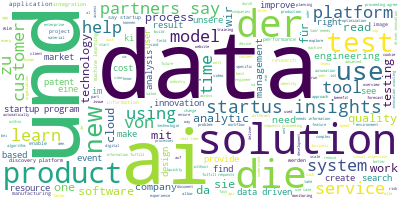

In [26]:
# Join the different processed keywords together.
long_string = ','.join(list(train_data['WebData'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [27]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary([long_string.split()])
# Create Corpus
texts = [long_string.split()]
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 3), (3, 5), (4, 5), (5, 2), (6, 2), (7, 7), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 13), (18, 1), (19, 1), (20, 1), (21, 1), (22, 31), (23, 2), (24, 3), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1)]


c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.011*"data" + 0.008*"und" + 0.005*"ai" + 0.005*"die" + 0.004*"der" + '
  '0.004*"insights" + 0.004*"partners" + 0.003*"platform" + 0.003*"innovation" '
  '+ 0.003*"business"'),
 (1,
  '0.011*"und" + 0.009*"data" + 0.006*"ai" + 0.005*"die" + 0.004*"der" + '
  '0.004*"insights" + 0.004*"use" + 0.004*"time" + 0.003*"von" + '
  '0.003*"business"'),
 (2,
  '0.010*"data" + 0.009*"und" + 0.006*"ai" + 0.004*"insights" + '
  '0.004*"innovation" + 0.004*"information" + 0.004*"die" + 0.004*"sie" + '
  '0.003*"quality" + 0.003*"business"'),
 (3,
  '0.010*"data" + 0.008*"und" + 0.005*"ai" + 0.005*"der" + 0.004*"innovation" '
  '+ 0.004*"insights" + 0.004*"die" + 0.003*"startup" + 0.003*"partners" + '
  '0.003*"business"'),
 (4,
  '0.014*"data" + 0.007*"und" + 0.005*"die" + 0.005*"ai" + 0.004*"use" + '
  '0.004*"der" + 0.004*"platform" + 0.004*"business" + 0.004*"insights" + '
  '0.004*"innovation"'),
 (5,
  '0.011*"data" + 0.007*"und" + 0.005*"insights" + 0.004*"die" + 0.004*"der" + '
  '0

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.004110 -0.000070       1        1  98.743485
1      0.001726  0.002836       2        1   0.750275
18     0.001932 -0.000802       3        1   0.351769
17     0.001748  0.000982       4        1   0.119273
12     0.001610 -0.001335       5        1   0.033925
0     -0.001024 -0.000424       6        1   0.000085
16     0.000986 -0.000890       7        1   0.000085
14    -0.001128  0.000847       8        1   0.000085
13    -0.001158  0.000735       9        1   0.000085
11    -0.001020 -0.001059      10        1   0.000085
10    -0.000005 -0.000742      11        1   0.000085
9     -0.004744 -0.000159      12        1   0.000085
8     -0.000195 -0.000487      13        1   0.000085
7     -0.000110  0.000435      14        1   0.000085
6      0.000824 -0.000390      15        1   0.000085
5      0.000534  0.000145      16        1   0.000085
4     -0.000315 -0.000419      17        1   0.000085
3     -0.001359  0.000072      18        1   0.000085
2     -0.000252 -0.000254      19        1   0.000085
19    -0.002160  0.000979      20        1   0.000085, topic_info=              Term         Freq        Total Category  logprob  loglift
2258          data  1086.000000  1086.000000  Default  30.0000  30.0000
10430          und   584.000000   584.000000  Default  29.0000  29.0000
2623           die   377.000000   377.000000  Default  28.0000  28.0000
255             ai   278.000000   278.000000  Default  27.0000  27.0000
10079         time   282.000000   282.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4984   information     0.000143   251.235158  Topic20  -5.9372  -0.4026
397      analytics     0.000113   148.389931  Topic20  -6.1703  -0.1091
9897    technology     0.000118   175.618882  Topic20  -6.1290  -0.2362
11391           zu     0.000116   172.059290  Topic20  -6.1460  -0.2328
5753         learn     0.000113   177.133803  Topic20  -6.1724  -0.2883

[1732 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
20         1  0.797665         ablaufen
58         1  0.979410       accelerate
71         1  0.988594           access
82         1  0.951543          account
100        1  1.055234         acquires
...      ...       ...              ...
11256      1  1.021273        workforce
11276      1  1.133961  workspricinguse
11297      1  0.904130            wrong
11391      1  0.993843               zu
11391      2  0.005812               zu

[656 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 2, 19, 18, 13, 1, 17, 15, 14, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 20])

***
#### Database Connection

In [30]:
#establishing the connection
conn = psycopg2.connect(
   database="postgres", user='postgres', password='Chaitali@28', host='127.0.0.1', port= '5432'
)

conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("select version()")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Connection established to:  ('PostgreSQL 15.0, compiled by Visual C++ build 1914, 64-bit',)


In [31]:
#Droping COMPANIES table if already exists.
cursor.execute("DROP TABLE IF EXISTS COMPANIES")

#Creating table as per requirement
sql ='''CREATE TABLE COMPANIES(
   COMPANY_NAME CHAR(30) NOT NULL,
   RELEVANCE INT,
   WEBDATA TEXT,
   CATEGORY INT,
   PRODUCT TEXT NOT NULL,
   CONSTRAINT COMPANY_ID PRIMARY KEY (COMPANY_NAME,PRODUCT)
)'''
cursor.execute(sql)
print("Table created successfully........")
conn.commit()

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Table created successfully........


In [32]:
cursor.execute("""INSERT INTO COMPANIES(COMPANY_NAME, RELEVANCE, WEBDATA, CATEGORY, PRODUCT) 
   VALUES ('AI Agents', 1, 'tHIS WEBDATA yOu NEED', 4, 'AISA WAALA PRODUCT')""")

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
#Close the connection
cursor.close()
conn.close()

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# def embed_words(text):
#     temp = pd.DataFrame()
#     for word in text.split(' '):
#         try:
#             word_vec = embeddings[word]
#             temp = temp.append(pd.Series(word_vec), ignore_index = True)
#         except:
#             pass
#     doc_vector = temp.mean()
#     return doc_vector

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# train_vectors = pd.DataFrame()
# for text in train_data["WebData"]:
#     train_vectors = train_vectors.append(embed_words(text),ignore_index = True)
# train_vectors.shape

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# test_vectors = pd.DataFrame()
# for text in test_data["WebData"]:
#     test_vectors = test_vectors.append(embed_words(text),ignore_index = True)
# test_vectors.shape

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# model = AdaBoostClassifier(n_estimators=800, random_state = 1)
# model.fit(train_vectors, train_output)
# test_pred = model.predict(test_input)

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
#soup_initial = re.sub("\s{2,}[a-z]+\s{2,}", " ", soup.text,flags=re.IGNORECASE)
#print(clean_text(soup.text))

c:\users\chaitali bagwe\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
